# Convolutional Neural Network Notebook

This note book

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# base_dir = '/content/drive/MyDrive/Colab Notebooks/Flictionary'

In [2]:
from glob import glob
import ast
import cv2
import time
import ast
from tqdm import tqdm
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import datetime

from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.applications import MobileNet

BASE_SIZE = 256
# DP_DIR = os.path.join(base_dir, "shuffle_csv/")
# INPUT_DIR = os.path.join(base_dir, 'kaggle/')
DP_DIR = "../animals/shuffle_csv/"
INPUT_DIR = '../animals/'
NCSVS = 100
NCATS = 47

In [2]:
startTime = time.time()

In [3]:
#clean spaces in name
classes_path = os.listdir(INPUT_DIR + 'train_simplified/')
classes_path = sorted(classes_path, key=lambda s: s.lower())
class_dict = {x[:-4].replace(" ", "_"):i for i, x in enumerate(classes_path)}
labels = {x[:-4].replace(" ", "_") for i, x in enumerate(classes_path)}

n_labels = len(labels)
print("Number of labels: {}".format(n_labels))

# fileList = glob(INPUT_DIR + "train_simplified/*.csv")     

# n_files = n_labels 
# size = 80


Number of labels: 48


In [7]:
def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def draw_cv2(raw_strokes, size=256, lw=6):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for stroke in raw_strokes:
        for i in range(len(stroke[0]) - 1):
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), 255, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

#ADD DATA AUGMENTATION TO BOOST
def image_generator(size, batchsize, ks, lw=6):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing'] = df['drawing'].apply(ast.literal_eval)
                x = np.zeros((len(df), size, size))
                for i, raw_strokes in enumerate(df.drawing.values):
                    x[i] = draw_cv2(raw_strokes, size=size, lw=lw)
                x = x / 255.
                x = x.reshape((len(df), size, size, 1)).astype(np.float32)
                y = tf.keras.utils.to_categorical(df.y, num_classes=NCATS)
                yield x, y

def df_to_image_array(df, size=size, lw=6):
    df['drawing'] = df['drawing'].apply(ast.literal_eval)
    x = np.zeros((len(df), size, size))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i] = draw_cv2(raw_strokes, size=size, lw=lw)
    x = x / 255.
    x = x.reshape((len(df), size, size, 1)).astype(np.float32)
    return x


def draw_cv2_reshape_normalized(raw_strokes, size=size, lw=6):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for stroke in raw_strokes:
        for i in range(len(stroke[0]) - 1):
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), 255, lw)

    img = cv2.resize(img, (size, size))
    img = img / 255.
    img = img[:, :, np.newaxis]
    return img


In [5]:
data = pd.read_csv('../animals/shuffle_csv/train_k99.csv.gz', nrows=100, compression='gzip',
                   error_bad_lines=False)
data.head()

/Users/examsherpa/opt/anaconda3/envs/dl-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,countrycode,drawing,recognized,timestamp,word,y,cv
0,US,"[[[67, 51, 35, 12, 4], [29, 12, 9, 63, 121]], ...",True,2017-03-20 21:26:55.171300,dog,10,99
1,DE,"[[[85, 82, 76, 45, 25, 22, 20, 10, 11, 17, 26,...",True,2017-03-26 20:52:19.315680,mouse,24,99
2,US,"[[[59, 27, 0, 1, 14, 39, 55, 72, 88, 98, 102],...",True,2017-03-14 23:23:42.875140,giraffe,17,99
3,FR,"[[[16, 23, 35, 41, 48, 61, 75, 86, 99, 121, 13...",True,2017-01-02 12:26:28.429200,squirrel,41,99
4,US,"[[[124, 112, 97, 54, 44, 39, 36, 36, 42, 75, 9...",True,2017-04-01 03:46:14.556100,pig,30,99


In [8]:
STEPS = 1000
batchsize = 512
epochs = 20

In [9]:
valid_df = pd.read_csv(os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(NCSVS - 1)), nrows=30000)
x_valid = df_to_image_array(valid, size)
y_valid = tf.keras.utils.to_categorical(valid., num_classes=NCATS)
print(x_valid.shape, y_valid.shape)
print('Validation array memory {:.2f} GB'.format(x_valid.nbytes / 1024.**3 ))

(14085, 80, 80, 1) (14085, 47)
Validation array memory 0.34 GB


In [10]:
train_datagen = image_generator(size=size, batchsize=batchsize, ks=range(NCSVS - 1))

In [13]:
base_model = MobileNet(input_shape=(size, size, 1), include_top=False, weights=None, classes=n_labels)

# add a global spatial average pooling layer
x = base_model.output
x = Flatten()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
predictions = Dense(n_labels, activation='softmax')(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [14]:
model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy]
              )

In [15]:
lr_reduction = ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                 factor=0.5, 
                                 patience=5,
                                 min_delta=0.005, 
                                 mode='max', 
                                 cooldown=3, 
                                 verbose=1)
filepath = '/content/drive/MyDrive/Colab Notebooks/Flictionary/logs/log_cnn_2/model.{epoch:02d}-{val_loss:.2f}.hdf5'
mcp_save = ModelCheckpoint(filepath, 
                           verbose = 1, 
                           monitor = 'val_categorical_accuracy', 
                           mode = 'min')
log_dir = "/content/drive/MyDrive/Colab Notebooks/Flictionary/logs/log_cnn_2/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir=log_dir,
                             histogram_freq = 1,
                             update_freq = 'batch')
csv_logger = CSVLogger('/content/drive/MyDrive/Colab Notebooks/Flictionary/logs/log_cnn_2/log.csv')


In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 40, 40, 32)        288       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 40, 40, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 40, 40, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 40, 40, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 40, 40, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 40, 40, 32)        0     

In [17]:
history = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=epochs, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = [lr_reduction, mcp_save, tensorboard_cb, csv_logger]
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
1000/1000 [==============================] - 380s 363ms/step - loss: 3.2820 - categorical_crossentropy: 3.2820 - categorical_accuracy: 0.1342 - top_3_accuracy: 0.2908 - val_loss: 2.9017 - val_categorical_crossentropy: 2.9017 - val_categorical_accuracy: 0.2215 - val_top_3_accuracy: 0.4333

Epoch 00001: saving model to /content/drive/MyDrive/Colab Notebooks/Flictionary/logs/log_cnn_2/model.01-2.90.hdf5
Epoch 2/20
1000/1000 [==============================] - 364s 364ms/step - loss: 2.3306 - categorical_crossentropy: 2.3306 - categorical_accuracy: 0.3651 - top_3_accuracy: 0.5917 - val_loss: 2.0310 - val_categorical_crossentropy: 2.0310 - val_categorical_accuracy: 0.4447 - val_top_3_accuracy: 0.6766

Epoch 00002: saving model to /content/drive/MyDrive/Colab Notebooks/Flictionary/logs/log_cnn_2/model.02-2.03.hdf5
Epoch 3/20
1000/1000 [==============================] - 356s 356ms/step - loss: 1.7221 - categorical_crossentropy: 1.7221 - categorical_accuracy: 0.5237 - top_3_accuracy:

In [18]:
def gen_graph(history, title):
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.plot(history.history['top_3_accuracy'])
    plt.plot(history.history['val_top_3_accuracy'])
    plt.title('Accuracy ' + title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation', 'Test top 3', 'Validation top 3'], loc='upper left')
    plt.show()
    plt.plot(history.history['categorical_crossentropy'])
    plt.plot(history.history['val_categorical_crossentropy'])
    plt.title('Loss ' + title)
    plt.ylabel('MLogLoss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

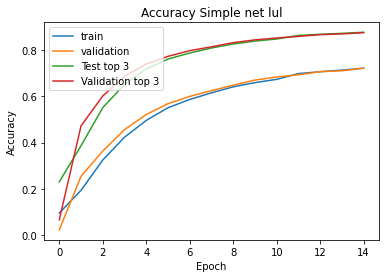

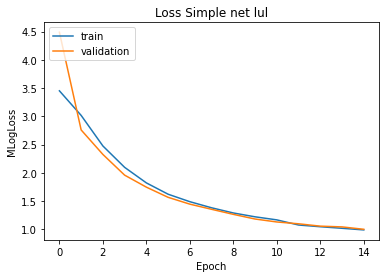

In [ ]:
#plot
gen_graph(history, "Simple net lul")

In [19]:
pred_results = []
chunksize = 10000
reader = pd.read_csv(INPUT_DIR + 'test_simplified.csv', chunksize=chunksize)
for chunk in tqdm(reader):
    imgs = df_to_image_array(chunk)
    pred = model.predict(imgs, verbose=1)
    top_3 =  np.argsort(-pred)[:, 0:3]  
    pred_results.append(top_3)
print("Finished test predictions...")


0it [00:00, ?it/s]

313/313 [==============================] - 2s 5ms/step


1it [00:09,  9.22s/it]

313/313 [==============================] - 1s 4ms/step


2it [00:16,  7.83s/it]

313/313 [==============================] - 1s 4ms/step


3it [00:21,  6.80s/it]

313/313 [==============================] - 1s 4ms/step


4it [00:28,  6.74s/it]

313/313 [==============================] - 1s 4ms/step


5it [00:35,  6.81s/it]

313/313 [==============================] - 1s 4ms/step


6it [00:42,  6.84s/it]

313/313 [==============================] - 1s 4ms/step


7it [00:47,  6.40s/it]

313/313 [==============================] - 1s 4ms/step


8it [00:54,  6.55s/it]

313/313 [==============================] - 1s 4ms/step


9it [01:00,  6.26s/it]

313/313 [==============================] - 1s 4ms/step


10it [01:05,  6.05s/it]

313/313 [==============================] - 1s 4ms/step


11it [01:11,  5.89s/it]

69/69 [==============================] - 0s 5ms/step


12it [01:12,  6.06s/it]

Finished test predictions...


In [20]:
#prepare data for saving
reverse_dict = {v: k for k, v in class_dict.items()}
pred_results = np.concatenate(pred_results)
print("Finished data prep...")


Finished data prep...


In [21]:
preds_df = pd.DataFrame({'first': pred_results[:,0], 'second': pred_results[:,1], 'third': pred_results[:,2]})
preds_df = preds_df.replace(reverse_dict)

preds_df['words'] = preds_df['first'] + " " + preds_df['second'] + " " + preds_df['third']

sub = pd.read_csv(INPUT_DIR + 'sample_submission.csv', index_col=['key_id'])
sub['word'] = preds_df.words.values
sub.to_csv('1class_per_label_proto.csv')
sub.head()

,word
key_id,
9000003627287624,crocodile tiger swan
9000010688666847,bat rhinoceros tiger
9000023642890129,camel bat rhinoceros
9000038588854897,monkey raccoon horse
9000052667981386,pig zebra cat


In [22]:
endTime = time.time()
print(endTime - startTime)

8143.678502559662
